In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation



In [2]:
dim = 2  # Number of room dimensions.
T = 100  # Simulation duration T
dt = 0.005  # time step or increment dt [s].

In [3]:
# initial positions of particles [m]  (x,y)
# limit to six identical particles that can move in a rectangular field
# store the initial positions of the particles in a 6 × 2 array:
r0 = np.array([[-1.0, 0.0],  [0.5, 0.0], [0.45, -0.05],
               [0.45, 0.05], [0.55, -0.05], [0.55, 0.05]])
r0

array([[-1.  ,  0.  ],
       [ 0.5 ,  0.  ],
       [ 0.45, -0.05],
       [ 0.45,  0.05],
       [ 0.55, -0.05],
       [ 0.55,  0.05]])

In [4]:

# Number of particles.
N = r0.shape[0]
N

6

In [18]:

# Initial speeds [m/s].
# all initial speeds is zero.
# Only the first particle should move to the right with a speed of 3 m/s.
v = np.zeros((N, dim))
print(v)

v[0] = np.array([3.0, 0.0])  # velocity of first object is only along x axis

print(f"v0 ={v[0]} ")
print(v)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
v0 =[3. 0.] 
[[3. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [6]:
# radii of the individual particles [m]
# create an array that contains the radius for each individual sphere.
radius = 0.03 * np.ones(N)
print(radius)
m = 0.2 * np.ones(N)
print(m)

[0.03 0.03 0.03 0.03 0.03 0.03]
[0.2 0.2 0.2 0.2 0.2 0.2]


In [7]:
# Hessian normal form , in which a normal vector and the
# distance from the coordinate origin are specified for each plane (or straight line)
# For each wall, the distance from the coordinate origin
# wall_d and an outward-pointing normal vector wall_n specified.
# The first two items set the limits at x = ±1.2 m
# and the following items set the limits at y = ±0.6 m.
wall_d = np.array([1.2, 1.2, 0.6, 0.6])
wall_n = np.array([[-1.0, 0], [1.0, 0], [0, -1.0], [0, 1.0]])
print(wall_d)
print(wall_n)

[1.2 1.2 0.6 0.6]
[[-1.  0.]
 [ 1.  0.]
 [ 0. -1.]
 [ 0.  1.]]


In [8]:
# Smallest time difference at which collisions than simultaneously be accepted [s].
epsilon = 1e-9

# Create arrays for the simulation result.
t = np.arange(0, T, dt)
r = np.empty((t.size, N, dim))
r[0] = r0
print(f"t = {t}")
print(f"r = {r}")
print(f"r[0] = {r[0]}")

t = [0.0000e+00 5.0000e-03 1.0000e-02 ... 9.9985e+01 9.9990e+01 9.9995e+01]
r = [[[-1.    0.  ]
  [ 0.5   0.  ]
  [ 0.45 -0.05]
  [ 0.45  0.05]
  [ 0.55 -0.05]
  [ 0.55  0.05]]

 [[ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]]

 [[ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]]

 ...

 [[ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]]

 [[ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]]

 [[ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]
  [ 0.    0.  ]]]
r[0] = [[-1.    0.  ]
 [ 0.5   0.  ]
 [ 0.45 -0.05]
 [ 0.45  0.05]
 [ 0.55 -0.05]
 [ 0.55  0.05]]


In [9]:
def collision_time(r, v):
    """Indicates the time until the next particle collision and the indices of the participating particles. """
    # Create N x N x dim arrays that match the pairwise
    # Location and speed differences included:
    # dr[i, j] is the vector r[i] - r[j]
    # dv[i, j] is the vector v[i] - v[j]
    dr = r.reshape(N, 1, dim) - r
    dv = v.reshape(N, 1, dim) - v
    # Create an N x N array containing the squared absolute value of the
    # Contains vectors from array dv.
    dv2 = np.sum(dv * dv, axis=2)
    # Create an N x N array containing the pairwise sum
    # contains the radii of the particles.
    rad = radius + radius.reshape(N, 1)
    # To determine the time of the collision,
    # form quadratic equation  t² + 2 a t + b = 0
    # be resolved. Only the smaller solution is relevant.
    a = np.sum(dv * dr, axis=2) / dv2
    b = (np.sum(dr * dr, axis=2) - rad ** 2) / dv2
    D = a ** 2 - b
    t = -a - np.sqrt(D)
    # Find the smallest positive instant of a collision.
    t[t <= 0] = np.NaN
    t_min = np.nanmin(t)
    # Find the corresponding particle indices.
    i, j = np.where(np.abs(t - t_min) < epsilon)
    # Select the first half of the indices because each
    # Particle pairing occurs twice.
    i = i[0:i.size // 2]
    j = j[0:j.size // 2]
    # Return time and particle indices. if
    # no collision occurs, then return inf.
    if np.isnan(t_min):
        t_min = np.inf

    return t_min, i, j


In [10]:

def boundary_of_sim(r, v):
    """Returns the time until the next wall collision, the index of the particles and the index of the wall."""
    # Calculate the time of the collision of the particles
    # one of the walls. The result is an N x number of walls - arrays.
    distance = wall_d - radius.reshape(-1, 1) - r @ wall_n.T
    t = distance / (v @ wall_n.T)
    # Ignore all non-positive tenses.
    t[t <= 0] = np.NaN
    # Ignore all times when the particle moves
    # against the normal vector but due to
    # rounding errors it can happen that a particle is slightly outside a wall.
    t[(v @ wall_n.T) < 0] = np.NaN
    # Find the smallest point in time and give the time and the indices back.
    t_min = np.nanmin(t)
    particle, wall = np.where(np.abs(t - t_min) < epsilon)
    return t_min, particle, wall

In [11]:
# Calculate the time until the first collision and the
# partners involved.
dt_particle, particle1, particle2 = collision_time(r[0], v)
dt_wall, particle_w, wall = boundary_of_sim(r[0], v)
dt_collision = min(dt_particle, dt_wall)

print(f"dt_particle = {dt_particle}")
print(f"particle1 = {particle1}")
print(f"particle2 = {particle2}")

print(f"dt_wall = {dt_wall}")
print(f"particle_w = {particle_w}")
print(f"wall = {wall}")
print(f"dt_collision  = {dt_collision }")

dt_particle = 0.47227791736548463
particle1 = [0 0]
particle2 = [2 3]
dt_wall = 0.7233333333333333
particle_w = [0]
wall = [1]
dt_collision  = 0.47227791736548463


/tmp/ipykernel_6156/236699363.py:18: RuntimeWarning: invalid value encountered in divide
  a = np.sum(dv * dr, axis=2) / dv2
/tmp/ipykernel_6156/236699363.py:19: RuntimeWarning: divide by zero encountered in divide
  b = (np.sum(dr * dr, axis=2) - rad ** 2) / dv2
/tmp/ipykernel_6156/3310311755.py:6: RuntimeWarning: divide by zero encountered in divide
  t = distance / (v @ wall_n.T)


In [12]:

# Loop over the time steps.
for i in range(1, t.size):
    # Copy the positions from the previous time step.
    r[i] = r[i - 1]

    # Time that has already been simulated in this time step.
    t1 = 0

    # Handle all collisions in this one in turn timestep
    while t1 + dt_collision <= dt:
        # Move all particles forward until collision.
        r[i] += v * dt_collision

        # Collisions between particles among themselves.
        if dt_particle <= dt_wall:
            for k1, k2 in zip(particle1, particle2):
                dr = r[i, k1] - r[i, k2]
                dv = v[k1] - v[k2]
                er = dr / np.linalg.norm(dr)
                m1 = m[k1]
                m2 = m[k2]
                v1_s = v[k1] @ er
                v2_s = v[k2] @ er

                v1_s_new = (2 * m2 * v2_s + (m1 -m2) * v1_s) / (m1 + m2)
                v2_s_new = (2 * m1 * v1_s + (m2 - m1) * v2_s) / (m1 + m2)

                v[k1] += (v1_s_new - v1_s) * er
                v[k2] += (v2_s_new - v2_s) * er

        # Collisions between particles and walls.
        if dt_particle >= dt_wall:
            for n, w in zip(particle_w, wall):
                v1_s = v[n] @ wall_n[w]
                v[n] -= 2 * v1_s * wall_n[w]

        # Within this time step Duration dt_collision already handled.
        t1 += dt_collision

        # Since collisions have taken place, we need these recalculate.
        dt_particle, particle1, particle2 = collision_time(r[i], v)
        dt_wall, particle_w, wall = boundary_of_sim(r[i], v)
        dt_collision = min(dt_particle, dt_wall)

    # Now find until the end of the current time step (dt)
    # no more collision. We move all particles
    # forward to the end of the time step and don't have to
    # Check for collisions again.

    r[i] += v * (dt - t1)
    dt_collision -= dt - t1

/tmp/ipykernel_6156/236699363.py:18: RuntimeWarning: invalid value encountered in divide
  a = np.sum(dv * dr, axis=2) / dv2
/tmp/ipykernel_6156/236699363.py:19: RuntimeWarning: divide by zero encountered in divide
  b = (np.sum(dr * dr, axis=2) - rad ** 2) / dv2
/tmp/ipykernel_6156/236699363.py:21: RuntimeWarning: invalid value encountered in sqrt
  t = -a - np.sqrt(D)
/tmp/ipykernel_6156/3310311755.py:6: RuntimeWarning: divide by zero encountered in divide
  t = distance / (v @ wall_n.T)
/tmp/ipykernel_6156/236699363.py:24: RuntimeWarning: All-NaN slice encountered
  t_min = np.nanmin(t)


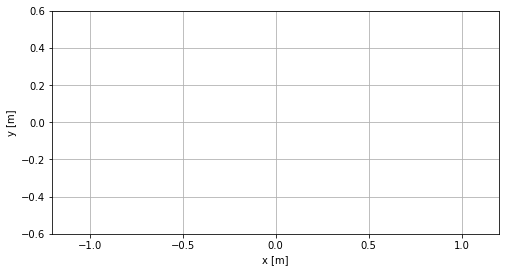

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-0.6, 0.6])
ax.set_aspect('equal')
ax.grid()


In [14]:

# Create a circle for each particle.
circle = []
for i in range(N):
    c = mpl.patches.Circle([0, 0], radius[i])
    ax.add_artist(c)
    circle.append(c)






In [15]:

def update(n):
    for i in range(N):
        circle[i].set_center(r[n, i])
    return circle

In [16]:
ani = mpl.animation.FuncAnimation(fig, update, interval=30,
                                  frames=t.size, blit=True)
ani

In [17]:
plt.show()